In [1]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from keras.models import Sequential  
from keras.layers import Dense, LSTM, Dropout 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# plot open vs date (training)
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=MSFT&outputsize=full&apikey=WIGVQ9248GZG5TU3&datatype=csv'

In [4]:
full = pd.read_csv(url)
full.shape

(5033, 9)

In [19]:
full.head()

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
0,2019-11-21,149.40,149.80,148.51,149.48,149.4800,16125077,0.00,1.0
1,2019-11-20,150.31,150.84,148.46,149.62,149.6200,25696800,0.51,1.0
2,2019-11-19,150.88,151.33,150.20,150.39,149.8800,23935700,0.00,1.0
3,2019-11-18,150.07,150.55,148.98,150.34,149.8302,21534000,0.00,1.0
4,2019-11-15,148.93,149.99,148.27,149.97,149.4614,23485700,0.00,1.0


In [5]:
train = full.head(int(full.shape[0]*0.7))
test = full.tail(int(full.shape[0]*0.3))

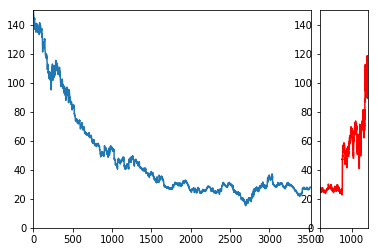

In [6]:
fg1 = plt.subplot2grid((1,6),(0,0), rowspan=1, colspan=5)
fg2 = plt.subplot2grid((1,6),(0,5), rowspan=1, colspan=1)

fg1.plot(train['open'].values)
fg1.set_xlim([0,train.shape[0]])
fg1.set_ylim([0,150])

fg2.plot(test['open'].values,color='red')
fg2.set_xlim([0,test.shape[0]])
fg2.set_ylim([0,150])

plt.show()

In [ ]:
# training_complete = train
# training_processed = pd.DataFrame(training_complete.iloc[:, 0:2].values,columns=['Date','Open'])
# training_processed = training_processed.set_index('Date')
# training_processed.head()

In [7]:
train_processed = train.iloc[:, 1:2].values
test_processed = test.iloc[:, 1:2].values
print(train_processed.shape,test_processed.shape)

(3523, 1) (1509, 1)


In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
train_scaled = scaler.fit_transform(train_processed)
test_scaled = scaler.fit_transform(test_processed)

In [9]:
print("Train\n",train_scaled,"\n---------------\nTest")
print(test_scaled)

Train
 [[0.98909198]
 [0.99579894]
 [1.        ]
 ...
 [0.09279186]
 [0.09286557]
 [0.09375   ]] 
---------------
Test
[[0.05474711]
 [0.05526832]
 [0.05245382]
 ...
 [0.69575324]
 [0.69249051]
 [0.69639953]]


In [10]:
features_set = []  
labels = []
for i in range(60, train_scaled.shape[0]):  
    features_set.append(train_scaled[i-60:i,0])
    labels.append(train_scaled[i,0])

features_set, labels = np.array(features_set), np.array(labels)  

features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))  

In [11]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set.shape[1], 1)))  
model.add(Dropout(0.2))  
model.add(LSTM(units=50, return_sequences=True))  
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))  
model.add(Dropout(0.2))

model.add(LSTM(units=50))  
model.add(Dropout(0.2))  

model.add(Dense(units = 1)) 
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 60, 50)            20200     
______________

In [13]:
model.fit(features_set, labels, epochs = 10, batch_size = 32) 

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
3463/3463 [==============================] - 34s - loss: 0.0072    
Epoch 2/10
3463/3463 [==============================] - 30s - loss: 0.0013    
Epoch 3/10
3463/3463 [==============================] - 30s - loss: 0.0011    
Epoch 4/10
3463/3463 [==============================] - 30s - loss: 0.0012    
Epoch 5/10
3463/3463 [==============================] - 31s - loss: 0.0010    
Epoch 6/10
3463/3463 [==============================] - 31s - loss: 8.6237e-04    
Epoch 7/10
3463/3463 [==============================] - 31s - loss: 8.4481e-04    
Epoch 8/10
3463/3463 [==============================] - 29s - loss: 8.7625e-04    
Epoch 9/10
3463/3463 [==============================] - 29s - loss: 9.7055e-04    
Epoch 10/10
3463/3463 [==============================] - 29s - loss: 8.5701e-04    


In [14]:
from keras.models import load_model

model.save('Django app/outputs/saved_models/stocks.h5')

In [15]:
model = load_model('Django app/outputs/saved_models/stocks.h5')

test_features = []  
for i in range(60, test_scaled.shape[0]):  
    test_features.append(test_scaled[i-60:i, 0])

test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))  

In [16]:
predictions = model.predict(test_features)  
print("Test\n",test_scaled,"\n---------------\nPredict")
print(predictions)

Test
 [[0.05474711]
 [0.05526832]
 [0.05245382]
 ...
 [0.69575324]
 [0.69249051]
 [0.69639953]] 
---------------
Predict
[[0.04957371]
 [0.05040638]
 [0.05115656]
 ...
 [0.76043063]
 [0.74962103]
 [0.7394188 ]]


In [17]:
scaler.inverse_transform(predictions) 

array([[27.573706],
       [27.653585],
       [27.725552],
       ...,
       [95.76763 ],
       [94.730644],
       [93.75192 ]], dtype=float32)

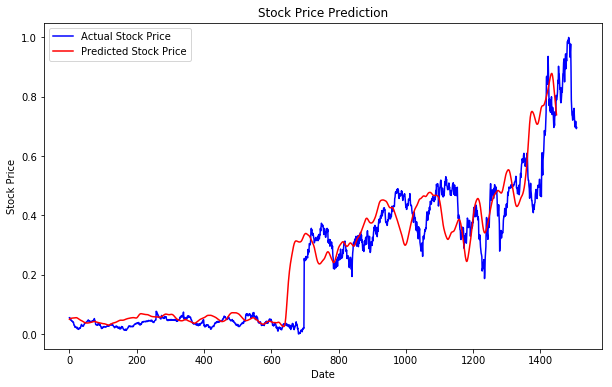

In [18]:
plt.figure(figsize=(10,6))  
plt.plot(test_scaled, color='blue', label='Actual Stock Price')  
plt.plot(predictions, color='red', label='Predicted Stock Price')  
plt.title('Stock Price Prediction')  
plt.xlabel('Date')  
plt.ylabel('Stock Price')  
plt.legend()  
plt.show()

In [31]:
model.predict(np.array([test_features[0]]))

array([[0.04957372]], dtype=float32)